Here we will investigate posterior estimates of a hierarchical linear regression model using various federated learning frameworks and comparing the quality of posterior estimates to centralised inference using sampling and stochastic variational inference methods.

## Hierarchical linear regression
We will start with the following linear regression example. Each node $n$ has collected a local dataset $\mathcal{D}_n$ of size $K_n = |\mathcal{D}_n|$. Each data set consists of input-output pairs $\mathcal{D}_n  = \left\{ (\pmb{x}^n_k, y^n_k)| \forall k \in \{1, \ldots, K_n\} \right\}$ where $\pmb{x}^n_k \in \mathbb{R}^{D}$, and $\pmb{y}^n_k \in ℝ$. We will assume the following generative model of the data

\begin{equation}
    \begin{split}
        \tau &\sim p(\tau|\tau_0) \\ 
        \lambda_i &\sim \mathcal{C}^+(0, \tau), \:\: \text{for } i \in \{1, \ldots, D\} \\
        \eta_{n,i} &\sim \mathcal{C}^+(0, \lambda_i), \:\: \text{for } n \in \{1, \ldots, N\} \\
        c_n^{-2} &\sim \Gamma(2, 2) \\
        \tilde{\eta}_{n, i}^2 &= \frac{c_n^2}{c_n^2 + \eta_{n, i}^2} \\
        \pmb{\beta}_{n,i} &\sim \mathcal{N}\left(0, \sigma_n^2 \tilde{\eta}_{n,i}^2 \right) \\
        y_n &\sim \mathcal{N} \left( \pmb{\beta}_n \cdot \pmb{x}^n, \sigma_n^2 \right)
    \end{split}
\end{equation}

In [11]:
from jax import lax, vmap, random
from numpyro import sample, plate, deterministic
import jax.numpy as jnp
import numpyro.distributions as dist
import arviz as az

from numpyro.infer import Predictive, MCMC, NUTS
from numpyro.handlers import condition
from fedbmr.feds import GenerativeModel

In [12]:
def global_prior(D=100, τ_0=1e-2):
    τ = sample('tau', dist.HalfCauchy(1.))
    with plate('dim', D):
        λ = sample('lambda', dist.HalfCauchy(1.))
    
    params = {
        'global': τ * λ * τ_0
    }

    return params

def local_prior(params, D=100, N=10):

    with plate('nodes_l', N):
        c = sample('c^{-2}', dist.Gamma(2, 2))
        var = sample('var', dist.Gamma(2, 2))
        eps = sample('eps', dist.Normal(0, 1.).expand([D]).to_event(1))
        with plate('dim_l', D):
            η = sample('eta', dist.HalfCauchy(1.))

    
    tilde_η = jnp.sqrt(η ** 2/(1 + c * η ** 2))
    scale = jnp.sqrt(var)
    beta = (scale * tilde_η).T * eps
    if params is not None:
        η = η.T * params['global']

    params['local'] = {
        'beta': deterministic('beta', beta), 
        'scale': jnp.sqrt(var)
    }

    return params

vinner = vmap(jnp.inner)

def likelihood(X, params, *, N=10, K=100):
    
    loc = vinner(params['local']['beta'], X)
    scale = params['local']['scale']
    with plate('nodes_m', N):
        with plate('data', K):
            sample('y', dist.Normal(loc, scale))

rng_key = random.PRNGKey(101)
rng_key, _rng_key = random.split(rng_key)
N  = 10
D  = 100

X = random.normal(_rng_key, shape=(N, D))

gp = lambda **kwargs: global_prior(D=D, **kwargs)
lp = lambda *args, **kwargs: local_prior(*args, N=N, D=D, **kwargs)
lkl = lambda *args, **kwargs: likelihood(X, *args, N=N, **kwargs)

gm = GenerativeModel(gp, lp, lkl)

rng_key, _rng_key = random.split(rng_key)
data = Predictive(gm, num_samples=1)(_rng_key)

In [10]:
lkl = condition(lkl, data={'y': data['y'][0]})

gm = GenerativeModel(gp, lp, lkl)

kernel = NUTS(gm)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)

rng_key, _rng_key = random.split(rng_key)
mcmc.run(_rng_key)

sample: 100%|██████████| 1500/1500 [06:44<00:00,  3.70it/s, 511 steps of size 6.58e-03. acc. prob=0.88]


In [14]:
idata = az.from_numpyro(mcmc)
az.loo(idata)

Computed from 1000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1295.02    27.78
p_loo       18.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Array([ 50.35714 ,  95.68653 , 107.017944,  55.81437 ,  44.518517,
        23.754814,  69.104355,  17.021656,  69.88074 ,  28.030611],      dtype=float32)

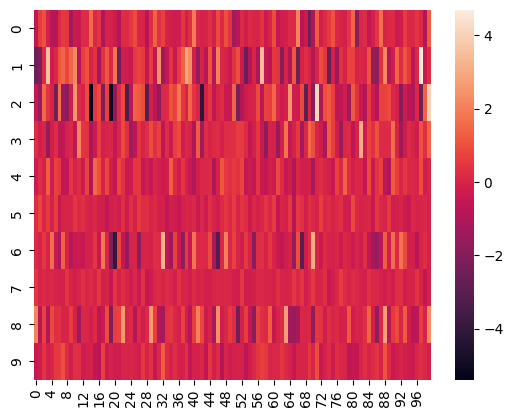

In [22]:
import seaborn as sns
sns.heatmap(data['beta'][0])
jnp.abs(data['beta'][0]).sum(-1)